<div style="position:relative;">
<img src=images/keras.png style="width: 60px; float: left" />
</div>
<div style="position:relative;">
<img src=images/keras.png style="width: 60px; float: right" />
</div>

# &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Keras


**Design Goals:**
  - User friendliness
  - Modularity
  - Easy extensibility
  - Work with Python

Keras is a high-level neural networks API, written in Python and capable of running on top of **TensorFlow**, **CNTK**, or **Theano**. It was developed with a focus on enabling fast experimentation. 
Allows for easy and fast prototyping (through user friendliness, modularity, and extensibility).
Supports both convolutional networks and recurrent networks, as well as combinations of the two.
Runs seamlessly on CPU and GPU.

# MNIST

The MNIST database (Modified National Institute of Standards and Technology database) is a **dataset**
  - 28x28 images showing handwritten digits
  - 55K training, 5K validation and 10K test samples
  - multi-class classification task

The MNIST dataset is the **hello world** task of (image-based) machine learning.
Throughout this tutorial we will stick to the MNIST dataset to keep things as simple as possible.
But of course you can later apply your new knowledge to something completely different (e.g. astro-particle physics)

Each image is represented by a 784-dimensional vector, and its label is represented by a 10-dimensional one-hot encoded vector. So, for instance the digit 3 would have the label (0,0,1,0,0,0,0,0,0,0)

In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")

/home/thomas/venv/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


It is always a good idea to first visualize some training samples, to get to know the data.

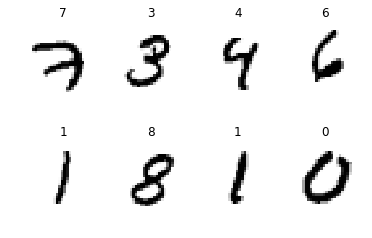

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 4)
for i, ax in enumerate(axes.flat):
    ax.set_title(mnist.train.labels[i])
    ax.imshow(mnist.train.images[i].reshape(28,28), cmap=plt.cm.Greys)
    ax.axis('off')

## tf.keras

Tensorflow officially supports the **keras** API

### Model 

In Keras you define your neural network as a **sequence of layers**.

Below you see a simple model using one convolutional layer, max-pooling followed by a single dense layer which directly provides the output using a softmax activation function. This is the same model as we wrote at the end of the Tensorflow notebook.

In [3]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Reshape((28, 28, 1), input_shape=[28*28]))
model.add(tf.keras.layers.Conv2D(32, kernel_size=(5, 5), strides=(1,1),
                                 padding="same", activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10, activation='softmax'))

A very useful feature is the `summary` method of the model.
It directly tells you the shape of the `tf.Tensor`s after each layer and the number of associated parameters in each layer.

As you can see by far the most parameters are in the final dense layer. In image recognition this is often the case, and the reason why you may want to consider using a global-pooling layer instead of just a simple 2 by 2 pooling (see DeepLearning lecture)

In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                62730     
Total params: 63,562
Trainable params: 63,562
Non-trainable params: 0
_________________________________________________________________


### Compile

Before you can train a model you have to compile it.
Internally this takes care of the underlying `tf.Graph` and `tf.Session` objects.

We are using the cross-entropy loss function, which is the appropriate loss for a multi-class classification task.

Also we use the basic stochastic gradient descent, we will investigate the usage of more advanced optimizers later.

Finally we want to use the accuracy as a metric to evaluate the performance of our model.

In [5]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.SGD(lr=0.5),
              metrics=['accuracy'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


### Fitting

In [6]:
### This is just some visualization code, you can ignore this cell

from IPython.display import clear_output

class PlotLosses(tf.keras.callbacks.Callback):
    def __init__(self, n_epochs):
        self.n_epochs = n_epochs

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('acc'))
        self.val_losses.append(logs.get('val_acc'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="acc")
        plt.plot(self.x, self.val_losses, label="val_acc")
        plt.ylim(0.8, 1.0)
        plt.xlim(0, self.n_epochs)
        plt.legend(loc=2)
        plt.show();

We fit our model using our training data.
  - The first arguments are the features (in this case the images)
  - The second argument are the labels (the utility function to_categorical performs a one-hot encoding of the labels)
  - Further arguments define the batch-size, the number of epochs (how often we cycle through the training data)
  - The callback argument can be used to call custom functions during the training, here we use it to plot the training progress
  - The validation_data argument provides an additional validation data set, which can be used to monitor the training progress on an independent dataset.
  
Depending on you computer you can change the number of training events you use.
There are 55K training events, and usually you want to use all of them. But for the workshop you may want to use just a few thousands. You don't want to waste our valuable time waiting an hour for the training to finish!

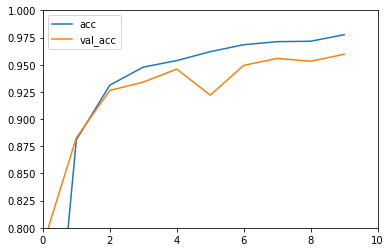

In [7]:
nevents = 5000
model.fit(mnist.train.images[:nevents],
          tf.keras.utils.to_categorical(mnist.train.labels[:nevents], 10),
          batch_size=256, epochs=10, callbacks=[PlotLosses(10)], verbose=0,
          validation_data=(mnist.validation.images, 
                           tf.keras.utils.to_categorical(mnist.validation.labels, 10)))

### Evaluation

Now the most important step. The evaluation. As we heard in the lecture **always test your model on an independent test dataset in the end!** We will follow this advice here.

Our model yields a good performance (>96% accuracy) on the independent test dataset.

In [8]:
model.evaluate(mnist.test.images, tf.keras.utils.to_categorical(mnist.test.labels, 10), verbose=0)

[0.1268268010802567, 0.9606]

### Prediction

Finally we want to use our model to do a prediction; here we just predict the first 8 elements.

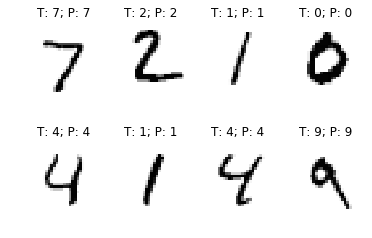

In [9]:
prediction = model.predict(mnist.test.images[:8])

fig, axes = plt.subplots(2, 4)
for i, ax in enumerate(axes.flat):
    ax.set_title("T: {}; P: {}".format(mnist.test.labels[i], prediction[i].argmax()))
    ax.imshow(mnist.test.images[i].reshape(28,28), cmap=plt.cm.Greys)
    ax.axis('off')

<div class="alert alert-block alert-info">
<h3>Exercise</h3>

Add regularization to the network by adding

<pre> kernel_regularizer=tf.keras.regularizers.l2(0.001), </pre>

as a parameter to the individual layers.
</div>

<div class="alert alert-block alert-info">
<h3>Exercise</h3>

Increase the depth of the above model by adding more convolution and pooling layers.<br>
How deep can you go before the training gets unstable.?
</div>

# Gaining Depth

In the lecture we discussed the **Vanishing Gradient Problem** and some techniques so avoid it.
  - **ReLU activation** 
  - **he initialization**
  - **batch normalization**

### Initialization

Setting the initialization in keras is easy, as in tensorflow most layers have a `kernel_initializer` parameter. As an argument to this parameter you can provide an initializer from the `tf.keras.initializer` module.
> kernel_initializer=tf.keras.initializers.he_normal()

### Batch normalization

Using Batch Normalization has a few pitfalls you have to know about.

Batch Normalization should be applied **before** the activation function. Hence you have to remove the `activation` parameter of the previous layer and instead apply the activation function by hand after adding the Batch Normalization layer. Also you can remove the bias from the previous layer (the bias will just be removed by the normalization step!).

> model.add(tf.keras.layers.Conv2D(..., use_bias=False))

> model.add(tf.keras.layers.BatchNormalization())

> model.add(tf.keras.layers.Activation('relu'))

### Global Average Pooling

In order to reduce the number of parameter of our model, we perform a **global average pooling** after the convolution layers and before the dense layers.
Remember that the most parameters of the model are usually contained in the dense layer.

In [10]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Reshape((28, 28, 1), input_shape=[28*28]))

for i in range(1, 4):
    model.add(tf.keras.layers.Conv2D(16*i, kernel_size=(3, 3), strides=(1,1),
                                     kernel_initializer=tf.keras.initializers.he_normal(),
                                     padding="same", use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))

model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(64, kernel_initializer=tf.keras.initializers.he_normal()))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dense(10, kernel_initializer=tf.keras.initializers.he_normal(), 
                                activation='softmax'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 16)        144       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 16)        64        
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        4608      
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 28, 28, 32)        0         
__________

Our model got a more complex. However, the model does contain fewer paramters (about a third!) in comparison to our previous model!

In [11]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.SGD(lr=0.5),
              metrics=['accuracy'])

### Callbacks

Callbacks are used in keras to perform specific actions after every batch or after each epoch. Previously we used a callback to update our accuracy plot during the training, now we add two more callbacks:
  - `tf.keras.callbacks.EarlyStopping` will automatically stop the training if the accuracy on the validation sample does no longer increase
  - `tf.keras.callbacks.ModelCheckpoint` will save the best model automatically
  
The **early stopping** provides a cheap and easy way to regularize our model.

In [12]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=10, mode='max', verbose=1),
             tf.keras.callbacks.ModelCheckpoint('checkpoints', monitor='val_acc', save_best_only=True, mode='max', verbose=1),
             PlotLosses(10)]

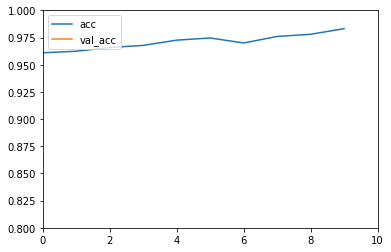

[0.7459862817764282, 0.727]

In [14]:
model.fit(mnist.train.images[:nevents],
          tf.keras.utils.to_categorical(mnist.train.labels[:nevents], 10),
          batch_size=256, epochs=10, callbacks=callbacks, verbose=0,
          validation_data=(mnist.validation.images, 
                           tf.keras.utils.to_categorical(mnist.validation.labels, 10)))

In [16]:
model.evaluate(mnist.test.images, tf.keras.utils.to_categorical(mnist.test.labels, 10), verbose=0)

[0.7459862817764282, 0.727]

<div class="alert alert-block alert-info">
<h3>Exercise</h3>
Modify the above model and observe how the number of parameters change.
<ul>
    <li>How many parameters are associated with a convolutional layer (as a function of kernel size, stride, and feature maps)</li>
    <li>How many parameters are associated with a dense layer (as a function of input and output layers)</li>
    <li>How many parameters are associated with the batch normalization layer</li>
    <li>How many parameters are associated with the pooling layer</li>
</ul>
</div>

<div class="alert alert-block alert-info">
<h3>Exercise</h3>
Use a different optimizer to train the model. For instance

<pre> optimizer=tf.keras.optimizers.Adam(), </pre>

</div>

# Recurrent Neural Network

As text-corpus we take the wikipedia article of France. But you can use anything you want:
  - twitter messages
  - books (project gutenberg)
  - newspaper articles
  
You may need to install the `wikipedia` package using pip3

In [3]:
import wikipedia
import unicodedata
text = wikipedia.page('France').content
text = unicodedata.normalize('NFKD', text).encode('ascii','ignore')
len(text), text[:100]

(128089,
 b'France (French: [fs]), officially the French Republic (French: Republique francaise [epyblik fsz]), ')

So far, we extensively studied image recognition. However, neural networks have a much broader spectrum of application.
Next, we will focus on building a simple character-based text-generation model.

### One-Hot Encoding

As explained in the lecture we can convert text into a suitable format for neural networks by mapping each character in the text to a number (here we use ascii encoding) and afterwards use `tf.keras.utils.to_categorical` to create a one-hot encoding

In [4]:
import numpy as np
def one_hot_encoding(binary_text):
    mapping = np.fromiter(binary_text, dtype=np.int8)
    return tf.keras.utils.to_categorical(mapping, 128)

one_hot_encoded_text = one_hot_encoding(text)

### Training Dataset

We split our text-corpus in pieces of 30 characters, our target will be the 31th character.

Like we did previously for the images we choose only a subset of the complete training dataset, depending on your machine you can change this value.

In [39]:
nevents = 30000
train_x = []
train_y = []
for i in range(30, len(one_hot_encoded_text)-31):
    train_x.append(one_hot_encoded_text[i:i+30])
    train_y.append(one_hot_encoded_text[i+31])
train_x = np.array(train_x[:nevents])
train_y = np.array(train_y[:nevents])

### LSTM Model

We use long short-term memory cells as the basic building block of our recurrent network.

The input shape is 30 (because we input 30 characters) x 128 (because the one-hot encoding is 128 dimensional)

The output are 128 probabilities, one for each possible character in the encoding.

In [6]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape=(30, 128)))
model.add(tf.keras.layers.Dense(128, activation='softmax'))
print(model.summary())

Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
Total params: 148,096
Trainable params: 148,096
Non-trainable params: 0
_________________________________________________________________
None


### Compilation

In [7]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.RMSprop(lr=0.01),
              metrics=['accuracy'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead


### Text Generation Callback

We use a callback to sample some text from the network after each epoch.

The sampling works by starting from a seed sentence, and afterwards iteratively predict the next character according to the probabilities outputted by the current model.

In [37]:
import sys
class TextGeneration(tf.keras.callbacks.Callback):
    def __init__(self, temperature=1.0):
        self.temperature = temperature
        self.choices = list(range(128))
        
    def on_epoch_end(self, epoch, logs={}):
        sentence = b'a country whose territory consists'[:30]
        print()
        sys.stdout.write(sentence)
        for i in range(200):
            preds = model.predict(np.array([one_hot_encoding(sentence)]), verbose=0)[0]
            a = np.log(preds) / self.temperature
            dist = np.exp(a)/np.sum(np.exp(a))
            next_char = bytes([np.random.choice(self.choices, p=dist)])
            sentence = sentence[1:] + next_char
            sys.stdout.write(next_char)
        sys.stdout.flush()
        print()

### Fitting

Finally we can start training our model end watch it learn!
Unfortunately the training can take a long time, so maybe let this just run even after the workshop ended.

In [41]:
model.fit(train_x, train_y, batch_size=256, epochs=10, callbacks=[TextGeneration()], verbose=1)

Epoch 1/10
29952/30000 [============================>.]29952/30000 [============================>.] - ETA: 0s - loss: 1.4385 - acc: 0.5871
a country whose territory consiue nter rien aoot hmeu rpierwsfin nmegorgaeu eand hmtoaoshr eeyat hsaha foc 1vrs sa itani Fars r135,0,wl eih nbt o tytgseinaid o hraae.Aetrur,clnae.I o hsohdCte nrak.A rvmig o erwoe naz,igdrena nrhss
30000/30000 [==============================]30000/30000 [==============================] - 77s 3ms/step - loss: 1.4387 - acc: 0.5871

Epoch 2/10
29952/30000 [============================>.]29952/30000 [============================>.] - ETA: 0s - loss: 1.3965 - acc: 0.5966
a country whose territory consiassom o 7'.nI lfdrtdcepid stddee,wrhtin dcnttry etadee  o hrloe fueesios i t femalase edetanesos adt hltre teeietnualc mmeriul foe epliy nesbtocudy e adiheCuhl ernis fudFan t rscile ra nedrbria d eli
30000/30000 [==============================]30000/30000 [==============================] - 74s 2ms/step - loss: 1.3974 - acc: 

/home/thomas/venv/lib/python3.5/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


dwrl efutos sou i 1 intwrn fud ntig ntay yay.Bt s npeaiafa fo oe atrcmltts eylciilu c  clrii ncadsttnu
30000/30000 [==============================]30000/30000 [==============================] - 75s 3ms/step - loss: 1.1577 - acc: 0.6539

